## Ch06 モデル評価・検証をTitanic号のデータで練習する

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image
%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context("notebook")
plt.style.use('dark_background')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [3]:
def get_unique(df,name):
    print('%s: %s'%(name, pd.unique(df[name])))

In [4]:
def get_dummy(df, keys):
    for key in keys:
        dummy = pd.get_dummies(df[key]).astype(np.int64)
        print("remove %s from %s"%(dummy.columns[0], key))
        dummy.columns = [key + '_' + i for i in dummy.columns]
        df = df.drop(key,axis=1)
        df = pd.concat([df, dummy.iloc[:,1:]], axis=1)
    return df

In [5]:
df = sns.load_dataset('titanic')

In [6]:
get_unique(df, 'sex')
get_unique(df, 'embarked')
get_unique(df, 'who')
get_unique(df, 'embark_town')
get_unique(df, 'alive')
get_unique(df, 'alone')
get_unique(df, 'adult_male')
get_unique(df, 'class')
get_unique(df, 'deck')

sex: ['male' 'female']
embarked: ['S' 'C' 'Q' nan]
who: ['man' 'woman' 'child']
embark_town: ['Southampton' 'Cherbourg' 'Queenstown' nan]
alive: ['no' 'yes']
alone: [False  True]
adult_male: [ True False]
class: [Third, First, Second]
Categories (3, object): [Third, First, Second]
deck: [NaN, C, E, G, D, A, B, F]
Categories (7, object): [C, E, G, D, A, B, F]


In [7]:
keys = ['who', 'sex', 'embarked', 'embark_town', 'deck']
df_cp = get_dummy(df, keys)

remove child from who
remove female from sex
remove C from embarked
remove Cherbourg from embark_town
remove A from deck


In [8]:
df_cp['alone'] = df_cp['alone'].map({True: 1, False: 0})
df_cp['adult_male'] = df_cp['adult_male'].map({True: 1, False: 0})

In [9]:
df_cp['class'] = df_cp['class'].map({'First': 1, 'Second': 2, 'Third': 3})

In [10]:
df_cp = df_cp.drop('alive', axis=1)
df_cp = df_cp.drop('pclass', axis=1)

In [11]:
df_cp['age'] = df_cp['age'].fillna(value=np.average(df_cp['age'].dropna()))

In [12]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
survived                   891 non-null int64
age                        891 non-null float64
sibsp                      891 non-null int64
parch                      891 non-null int64
fare                       891 non-null float64
class                      891 non-null int64
adult_male                 891 non-null int64
alone                      891 non-null int64
who_man                    891 non-null int64
who_woman                  891 non-null int64
sex_male                   891 non-null int64
embarked_Q                 891 non-null int64
embarked_S                 891 non-null int64
embark_town_Queenstown     891 non-null int64
embark_town_Southampton    891 non-null int64
deck_B                     891 non-null int64
deck_C                     891 non-null int64
deck_D                     891 non-null int64
deck_E                     891 non-null int64
deck_F           

In [13]:
# values指定を忘れるとSeriesとして保管され、あとのsklearnの処理がうまくいかない
X = df_cp.iloc[:,1:].values
y = df_cp.iloc[:,0].values

In [14]:
# train とtestにsplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [15]:
# パイプライン
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_test,y_test)

0.8156424581005587

In [16]:
# 層化k分割交差検証
from sklearn.model_selection import StratifiedKFold
sf = StratifiedKFold(n_splits=10, random_state=1)
kfold = sf.split(X_train, y_train)
trains = []
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f'%(k+1, np.bincount(y_train[train]), score))
    trains.append(train)

Fold:  1, Class dist.: [395 245], Acc: 0.764
Fold:  2, Class dist.: [395 245], Acc: 0.903
Fold:  3, Class dist.: [395 245], Acc: 0.847
Fold:  4, Class dist.: [395 246], Acc: 0.803
Fold:  5, Class dist.: [395 246], Acc: 0.775
Fold:  6, Class dist.: [395 246], Acc: 0.845
Fold:  7, Class dist.: [395 246], Acc: 0.803
Fold:  8, Class dist.: [395 246], Acc: 0.901
Fold:  9, Class dist.: [395 246], Acc: 0.817
Fold: 10, Class dist.: [396 246], Acc: 0.757


In [17]:
print('average score: %f'%(np.average(scores)))

average score: 0.821469


(0.6, 1.0)

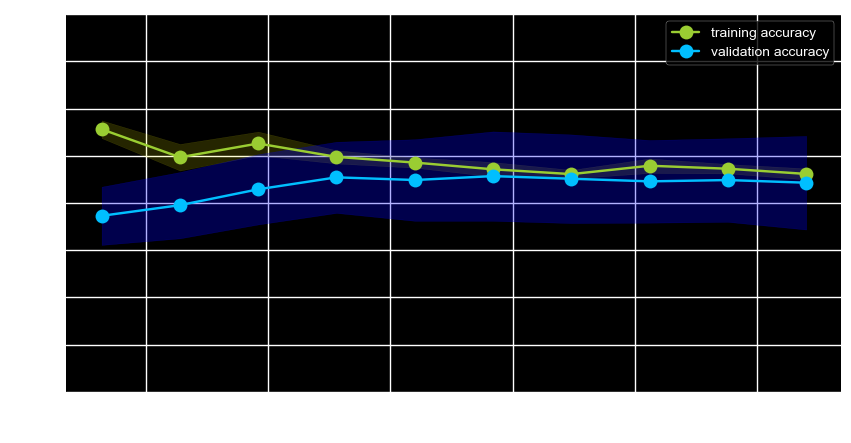

In [18]:
# 学習曲線
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                      X=X_train, y=y_train,
                                                      train_sizes=np.linspace(0.1,1.0,10 ),
                                                      cv = 10, n_jobs = 1)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis=1)
fig = plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_sizes, train_mean, color='yellowgreen', 
         marker='o', markersize=10, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                alpha = 0.15, color='yellow')
plt.plot(train_sizes, test_mean, color='deepskyblue',
        marker='o', markersize=10, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                alpha = 0.3, color='blue')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='upper right', frameon=True)
plt.ylim([0.6, 1.0])

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


(0.6, 1.0)

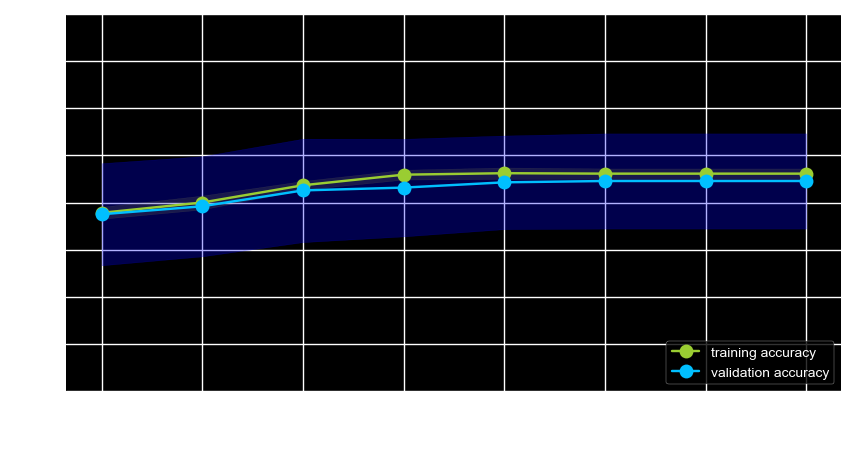

In [19]:
#検証曲線
from sklearn.model_selection import validation_curve
params = [10**(-4+i) for i in range(8)]
print(params)
train_scores, test_scores = validation_curve(estimator=pipe_lr,X=X_train, y=y_train,cv = 10,
                                             param_name='logisticregression__C',
                                             param_range=params)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis=1)
fig = plt.figure(figsize=(10,5), dpi=100)
plt.plot(params, train_mean, color='yellowgreen', 
         marker='o', markersize=10, label='training accuracy')
plt.fill_between(params, train_mean + train_std, train_mean - train_std,
                alpha = 0.15, color='yellow')
plt.plot(params, test_mean, color='deepskyblue',
        marker='o', markersize=10, label='validation accuracy')
plt.fill_between(params, test_mean + test_std, test_mean - test_std,
                alpha = 0.3, color='blue')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', frameon=True)
plt.xscale('log')
plt.ylim([0.6, 1.0])

In [20]:
### GridSearchを用いる
from sklearn.model_selection import GridSearchCV
params = [10**(-4+i) for i in range(8)]
param_grid = [{'logisticregression__C': params}]
gs = GridSearchCV(estimator=pipe_lr,param_grid=param_grid,
                 scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

{'logisticregression__C': 10}
0.8230337078651685


In [21]:
### SVM を試してみる
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1,verbose=10))
params = [10**(-4+i) for i in range(6)]
param_grid = [{'svc__C': params, 'svc__kernel': ['linear']},
             {'svc__C': params, 'svc__gamma': params, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,
                 scoring='accuracy', cv=10, n_jobs=4,verbose=10)

In [22]:
gs = gs.fit(X_train, y_train)

Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV] svc__C=0.0001, svc__kernel=linear ...............................
[CV] svc__C=0.0001, svc__kernel=linear ...............................
[CV] svc__C=0.0001, svc__kernel=linear ...............................
[CV] svc__C=0.0001, svc__kernel=linear ...............................
[LibSVM][CV]  svc__C=0.0001, svc__kernel=linear, score=0.6111111111111112, total=   0.0s
[LibSVM][CV]  svc__C=0.0001, svc__kernel=linear, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.0001, svc__kernel=linear ...............................
[LibSVM][CV]  svc__C=0.0001, svc__kernel=linear, score=0.6111111111111112, total=   0.0s
[LibSVM][CV]  svc__C=0.0001, svc__kernel=linear, score=0.6111111111111112, total=   0.0s
[CV] svc__C=0.0001, svc__kernel=linear ...............................
[CV] svc__C=0.0001, svc__kernel=linear ...............................
[CV] svc__C=0.0001, svc__kernel=linear ...............................
[LibSVM][CV] 

[Parallel(n_jobs=4)]: Batch computation too fast (0.0760s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s


[CV] svc__C=0.001, svc__kernel=linear ................................
[LibSVM][CV]  svc__C=0.01, svc__kernel=linear, score=0.8611111111111112, total=   0.0s
[CV] svc__C=0.01, svc__kernel=linear .................................
[LibSVM][CV]  svc__C=0.001, svc__kernel=linear, score=0.7746478873239436, total=   0.0s
[CV] svc__C=0.001, svc__kernel=linear ................................
[LibSVM][CV]  svc__C=0.001, svc__kernel=linear, score=0.8611111111111112, total=   0.0s
[CV] svc__C=0.01, svc__kernel=linear .................................
[LibSVM][CV]  svc__C=0.01, svc__kernel=linear, score=0.7746478873239436, total=   0.0s
[CV] svc__C=0.01, svc__kernel=linear .................................
[LibSVM][CV]  svc__C=0.01, svc__kernel=linear, score=0.8169014084507042, total=   0.0s
[CV] svc__C=0.01, svc__kernel=linear .................................
[LibSVM][CV] ...... svc__C=0.001, svc__kernel=linear, score=0.7, total=   0.0s
[LibSVM][CV]  svc__C=0.001, svc__kernel=linear, score=0.77

[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.3s


[LibSVM][CV]  svc__C=1, svc__kernel=linear, score=0.7916666666666666, total=   0.1s
[CV] svc__C=1, svc__kernel=linear ....................................
[LibSVM][CV]  svc__C=1, svc__kernel=linear, score=0.8028169014084507, total=   0.1s
[CV] svc__C=1, svc__kernel=linear ....................................
[LibSVM][CV]  svc__C=1, svc__kernel=linear, score=0.7605633802816901, total=   0.1s
[CV] svc__C=1, svc__kernel=linear ....................................
[LibSVM][CV]  svc__C=1, svc__kernel=linear, score=0.7571428571428571, total=   0.0s
[CV] svc__C=10, svc__kernel=linear ...................................
[LibSVM][CV] ........ svc__C=1, svc__kernel=linear, score=0.875, total=   0.1s
[CV] svc__C=1, svc__kernel=linear ....................................
[LibSVM][CV]  svc__C=1, svc__kernel=linear, score=0.8309859154929577, total=   0.0s
[CV] svc__C=1, svc__kernel=linear ....................................
[LibSVM][CV]  svc__C=1, svc__kernel=linear, score=0.8472222222222222, total

[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.7s


[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.0001, svc__gamma=0.0001, svc__kernel=rbf ...............
[LibSVM][CV]  svc__C=10, svc__kernel=linear, score=0.8169014084507042, total=   0.3s
[CV] svc__C=10, svc__kernel=linear ...................................
[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.0001, svc__gamma=0.0001, svc__kernel=rbf ...............
[LibSVM][CV]  svc__C=10, svc__kernel=linear, score=0.7887323943661971, total=   0.3s
[CV] svc__C=10, svc__kernel=linear ...................................
[LibSVM][CV]  svc__C=10, svc__kernel=linear, score=0.7916666666666666, total=   0.4s
[CV] svc__C=10, svc__kernel=linear ...................................
[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.0001, svc__gamma=0.0001, svc__kernel=rbf ...............
[Lib

[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    1.7s


[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf ..................
[CV] svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf ..................
[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[CV] svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf ..................
[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.01, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.0001, svc__gamma=0.01, svc__kernel=rbf .................
[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf ..................
[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[LibSVM][CV]  svc__C=0.0001, svc__gamma=0.1, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.0001, svc__gamma=0

[Parallel(n_jobs=4)]: Done 108 tasks      | elapsed:    2.2s


[LibSVM][CV]  svc__C=0.001, svc__gamma=0.0001, svc__kernel=rbf, score=0.6142857142857143, total=   0.0s
[LibSVM][CV]  svc__C=0.0001, svc__gamma=10, svc__kernel=rbf, score=0.6142857142857143, total=   0.0s
[CV] svc__C=0.001, svc__gamma=0.001, svc__kernel=rbf .................
[CV] svc__C=0.001, svc__gamma=0.001, svc__kernel=rbf .................
[LibSVM][CV]  svc__C=0.001, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.001, svc__gamma=0.0001, svc__kernel=rbf ................
[LibSVM][CV]  svc__C=0.001, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.001, svc__gamma=0.001, svc__kernel=rbf .................
[LibSVM][CV]  svc__C=0.001, svc__gamma=0.001, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[LibSVM][CV]  svc__C=0.001, svc__gamma=0.001, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[CV] svc__C=0.001, svc__gamma=0.001, svc__kernel=rbf .................
[CV] svc__C=0.001, svc__ga

[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.8s


[LibSVM][CV]  svc__C=0.001, svc__gamma=1, svc__kernel=rbf, score=0.6197183098591549, total=   0.1s
[LibSVM][CV]  svc__C=0.001, svc__gamma=1, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.001, svc__gamma=1, svc__kernel=rbf .....................
[CV] svc__C=0.001, svc__gamma=1, svc__kernel=rbf .....................
[LibSVM][CV]  svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf, score=0.6142857142857143, total=   0.0s
[CV] svc__C=0.001, svc__gamma=10, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=0.001, svc__gamma=1, svc__kernel=rbf, score=0.6142857142857143, total=   0.0s
[LibSVM][CV]  svc__C=0.001, svc__gamma=1, svc__kernel=rbf, score=0.6197183098591549, total=   0.1s
[LibSVM][CV]  svc__C=0.001, svc__gamma=1, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.001, svc__gamma=10, svc__kernel=rbf ....................
[CV] svc__C=0.001, svc__gamma=1, svc__kernel=rbf .....................
[CV] svc__C=0.001, svc__gamma=10, svc__kernel=rbf

[Parallel(n_jobs=4)]: Done 188 tasks      | elapsed:    3.5s


[LibSVM][CV]  svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf, score=0.6142857142857143, total=   0.0s
[CV] svc__C=0.01, svc__gamma=0.1, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf ...................
[LibSVM][CV]  svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf, score=0.6142857142857143, total=   0.0s
[CV] svc__C=0.01, svc__gamma=0.1, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.01, svc__gamma=0.1, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=0.01, svc__gamma=0.1, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[CV] svc__C=0.01, svc__gamma=0.1, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.01, svc__gamma=0.01, svc_

[Parallel(n_jobs=4)]: Done 232 tasks      | elapsed:    4.2s


[LibSVM][CV]  svc__C=0.1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.1, svc__gamma=0.0001, svc__kernel=rbf ..................
[LibSVM][CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf ...................
[LibSVM][CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf, score=0.6111111111111112, total=   0.1s
[CV] svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf ...................
[LibSVM][CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[CV] svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf ...................
[LibSVM][CV]  svc__C=0.1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[LibSVM][CV]  svc__C=0.1, svc__gamma=

[CV] svc__C=0.1, svc__gamma=10, svc__kernel=rbf ......................
[LibSVM][CV]  svc__C=0.1, svc__gamma=10, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[LibSVM][CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[LibSVM][CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[LibSVM][CV]  svc__C=0.1, svc__gamma=10, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV] svc__C=0.1, svc__gamma=10, svc__kernel=rbf .

[Parallel(n_jobs=4)]: Done 284 tasks      | elapsed:    5.1s


[LibSVM][CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6111111111111112, total=   0.0s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[LibSVM][CV]  svc__C=0.1, svc__gamma=10, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=0.1, svc__gamma=10, svc__kernel=rbf ......................
[LibSVM][CV]  svc__C=1, svc__gamma=0.001, svc__kernel=rbf, score=0.7777777777777778, total=   0.0s
[CV] svc__C=1, svc__gamma=0.001, svc__kernel=rbf .....................
[LibSVM][CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=1, svc__gamma=0.001, svc__kernel=rbf .....................
[LibSVM][CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.6197183098591549, total=   0.0s
[CV] svc__C=1, svc__gamma=0.001, svc__kernel=rbf .....................
[LibSVM][CV]  svc__C=0.1, svc__gamma=10, svc__kernel=rbf, score=0.6142857142857143, total=   0.0s
[CV] svc__C=1, svc__gamma=0.01, svc__kernel=rbf ..

[Parallel(n_jobs=4)]: Done 336 tasks      | elapsed:    5.8s


[LibSVM][CV]  svc__C=1, svc__gamma=10, svc__kernel=rbf, score=0.647887323943662, total=   0.0s
[CV] svc__C=1, svc__gamma=10, svc__kernel=rbf ........................
[LibSVM][CV]  svc__C=1, svc__gamma=10, svc__kernel=rbf, score=0.7183098591549296, total=   0.0s
[LibSVM][CV]  svc__C=1, svc__gamma=1, svc__kernel=rbf, score=0.8309859154929577, total=   0.0s
[CV] svc__C=10, svc__gamma=0.0001, svc__kernel=rbf ...................
[CV] svc__C=1, svc__gamma=10, svc__kernel=rbf ........................
[LibSVM][CV]  svc__C=1, svc__gamma=10, svc__kernel=rbf, score=0.7916666666666666, total=   0.0s
[CV] svc__C=10, svc__gamma=0.0001, svc__kernel=rbf ...................
[LibSVM][CV]  svc__C=1, svc__gamma=10, svc__kernel=rbf, score=0.704225352112676, total=   0.0s
[CV] svc__C=1, svc__gamma=10, svc__kernel=rbf ........................
[LibSVM][CV]  svc__C=10, svc__gamma=0.0001, svc__kernel=rbf, score=0.7638888888888888, total=   0.0s
[CV] svc__C=10, svc__gamma=0.0001, svc__kernel=rbf ................

[CV] svc__C=10, svc__gamma=1, svc__kernel=rbf ........................
[LibSVM][CV]  svc__C=10, svc__gamma=1, svc__kernel=rbf, score=0.676056338028169, total=   0.0s
[CV] svc__C=10, svc__gamma=1, svc__kernel=rbf ........................
[LibSVM][CV]  svc__C=10, svc__gamma=0.1, svc__kernel=rbf, score=0.8028169014084507, total=   0.0s
[CV] svc__C=10, svc__gamma=0.1, svc__kernel=rbf ......................
[LibSVM][CV]  svc__C=10, svc__gamma=1, svc__kernel=rbf, score=0.8194444444444444, total=   0.1s
[CV] svc__C=10, svc__gamma=1, svc__kernel=rbf ........................
[LibSVM][CV]  svc__C=10, svc__gamma=1, svc__kernel=rbf, score=0.6857142857142857, total=   0.0s
[CV] svc__C=10, svc__gamma=10, svc__kernel=rbf .......................
[LibSVM][CV]  svc__C=10, svc__gamma=0.1, svc__kernel=rbf, score=0.7285714285714285, total=   0.0s
[CV] svc__C=10, svc__gamma=10, svc__kernel=rbf .......................
[LibSVM][CV]  svc__C=10, svc__gamma=1, svc__kernel=rbf, score=0.8169014084507042, total=   

[Parallel(n_jobs=4)]: Done 420 out of 420 | elapsed:    7.1s finished


In [25]:
parameters = [mat[0] for mat in gs.grid_scores_]
score = [mat[1] for mat in gs.grid_scores_]
svc_lin_C = parameters[:len(params)]
svc_lin_C = [c['svc__C'] for c in parameters[:len(params)]]
svc_lin_score = score[:len(params)]
df_lin = pd.DataFrame(np.c_[svc_lin_C, svc_lin_score],columns=['C', 'score'])
svc_kernel_C = [c['svc__C'] for c in parameters[len(params):]]
svc_kernel_gamma = [g['svc__gamma'] for g in parameters[len(params):]]
svc_lin_score = score[len(params):]
df_kernel = pd.DataFrame(np.c_[svc_kernel_C,svc_kernel_gamma, svc_lin_score],columns=['C', 'gamma','score'])

/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [26]:
kernel_max = df_kernel.loc[df_kernel['score'].idxmax(),:]
lin_max = df_lin.loc[df_lin['score'].idxmax(),:]
df_kernel.head()

,C,gamma,score
0,0.0001,0.0001,0.616573
1,0.0001,0.0010,0.616573
2,0.0001,0.0100,0.616573
3,0.0001,0.1000,0.616573
4,0.0001,1.0000,0.616573


Text(0.5,1,'SVC kernel parameter validation curve')

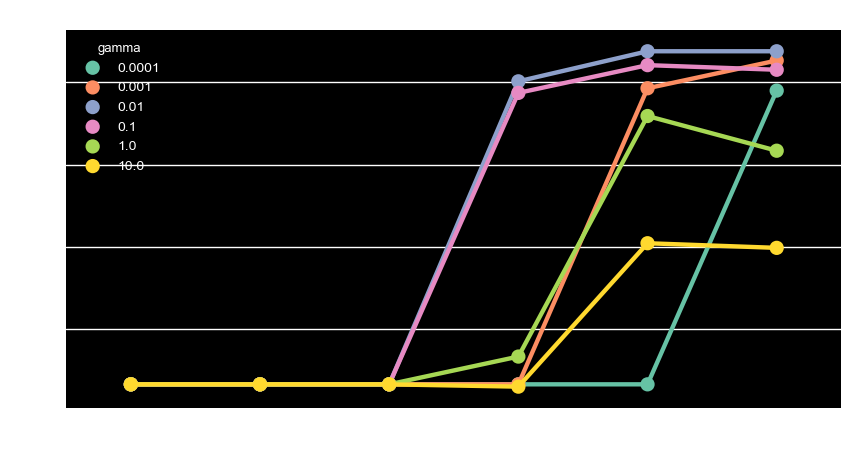

In [27]:
fig = plt.figure(figsize=(10,5), dpi=100)
g = sns.pointplot(x='C', y='score', data=df_kernel, hue='gamma', palette='Set2')
g.set_title('SVC kernel parameter validation curve')

Text(0.5,1,'SVC linear parameter validation curve')

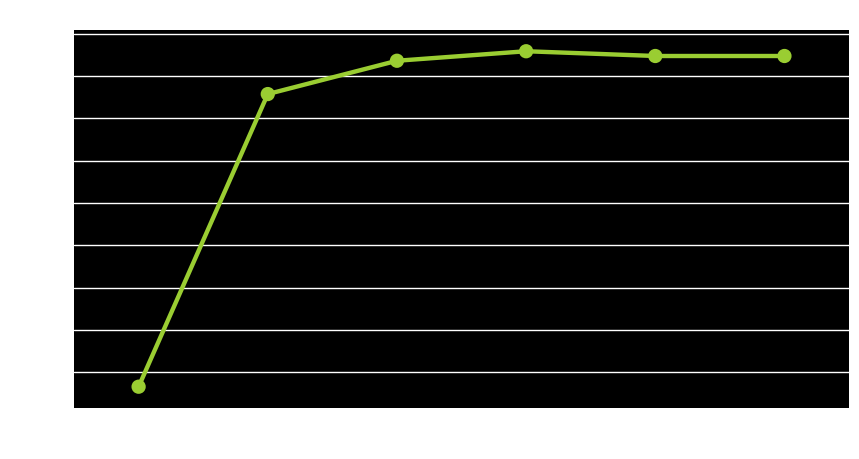

In [29]:
fig = plt.figure(figsize=(10,5), dpi=100)
g = sns.pointplot(x='C', y='score', data=df_lin, color='yellowgreen')
g.set_title('SVC linear parameter validation curve')

In [38]:
### モデル検証
from sklearn.model_selection import cross_val_score
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(random_state=1))
params_lr = [10**(-4+i) for i in range(6)]
param_grid_lr = [{'logisticregression__C': params_lr}]

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1,verbose=10))
params_svc = [10**(-4+i) for i in range(6)]
param_grid_svc = [{'svc__C': params_svc, 'svc__kernel': ['linear']},
             {'svc__C': params_svc, 'svc__gamma': params_svc, 'svc__kernel': ['rbf']}]

from sklearn.tree import DecisionTreeClassifier
pipe_tree = make_pipeline(DecisionTreeClassifier(random_state=0))
params_tree = [{'max_depth': [1,2,3,4,5,6,7,None]}]

In [39]:
### LinearRegression
gs = GridSearchCV(estimator=pipe_lr,param_grid=param_grid_lr,
                 scoring='accuracy', cv=2, n_jobs=-1)
gs = gs.fit(X_train, y_train)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print(' Linear Regression')
print('average: %f, variation: %f'% (np.mean(scores), np.std(scores)))
print('best is %s'% gs.best_params_)

 Linear Regression
average: 0.821585, variation: 0.024571
best is {'logisticregression__C': 10}


In [40]:
### SVM
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid_svc,
                 scoring='accuracy', cv=2, n_jobs=-1)
gs = gs.fit(X_train, y_train)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print(' Support Vector Machine')
print('average: %f, variation: %f'% (np.mean(scores), np.std(scores)))
print('best is %s'% gs.best_params_)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM] Support Vector Machine
average: 0.818739, variation: 0.020415
best is {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [42]:
### Decision Tree
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=params_tree,
                 scoring='accuracy', cv=2, n_jobs=-1)
gs.fit(X_train,y_train)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print(' Decision Tree')
print('average: %f, variation: %f'% (np.mean(scores), np.std(scores)))
print('best is %s'% gs.best_params_)

 Decision Tree
average: 0.803305, variation: 0.027094
best is {'max_depth': 6}


In [52]:
### Confusion Matrix
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(random_state=1, C=10))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
result = confusion_matrix(y_true=y_test, y_pred=y_pred)
PRE = precision_score(y_true=y_test, y_pred=y_pred)
REC = recall_score(y_true=y_test, y_pred=y_pred)
F1 = f1_score(y_true=y_test, y_pred=y_pred)
print(PRE)
print(REC)
print(F1)

0.78125
0.7246376811594203
0.7518796992481203


Text(10.2222,0.5,'true label')

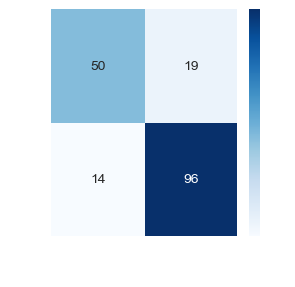

In [54]:
fig = plt.figure(figsize=(3,3), dpi=100)
g = sns.heatmap(result, annot=True, cmap='Blues')
g.invert_xaxis()
g.invert_yaxis()
g.set_xlabel('predicted label')
g.set_ylabel('true label')

In [56]:
### グリッドサーチの検証にF1値を使用
from sklearn.metrics import make_scorer, f1_score
my_score = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_lr,param_grid=param_grid_lr,
                 scoring=my_score, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print('best score(f1) is %f'%gs.best_score_)
print('best parameter is %s'% gs.best_params_)

best score(f1) is 0.856585
best parameter is {'logisticregression__C': 10}


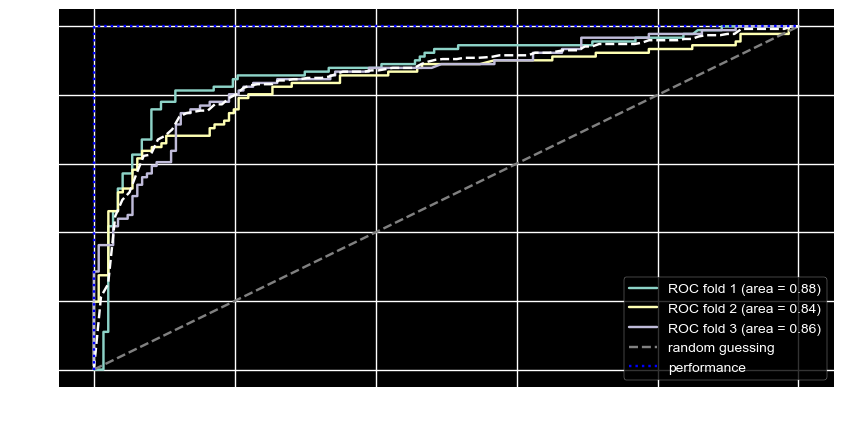

In [59]:
#ROC 曲線
from sklearn.metrics import roc_curve,auc
from scipy import interp
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []
fig = plt.figure(figsize=(10,5), dpi=100)
for i,(train, test) in enumerate(cv):
    fit = pipe_lr.fit(X_train[train], y_train[train])
    probas = fit.predict_proba(X_train[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)'%(i+1, roc_auc))

#当て推量
plt.plot([0,1], [0,1], linestyle='--', color='grey', label = 'random guessing')

#FRP, TRP, ROC AUC それぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', color='white')

#完全に予測が正解したとき
plt.plot([0,0,1],[0,1,1],linestyle=':', color='blue', label = 'performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('ture positive rate')
plt.legend(loc='lower right', frameon=True)

In [60]:
### PCAによる次元圧縮での評価　<敢えてパイプラインは使わない>
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.fit_transform(X_test)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

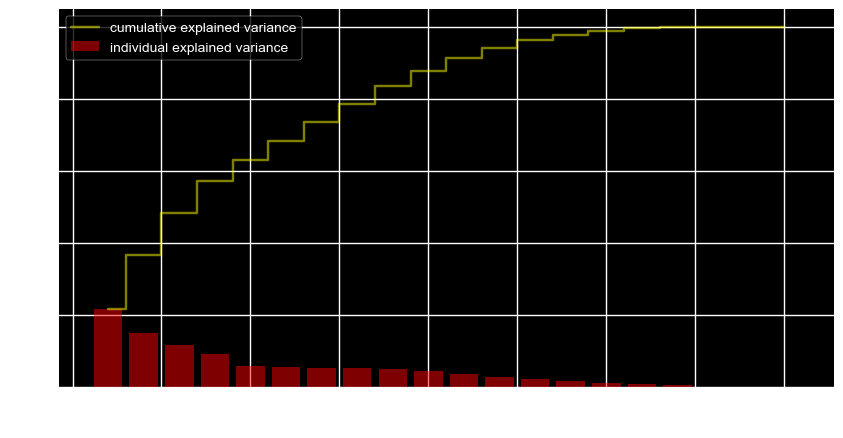

In [70]:
cov_mat = np.cov(X_train_std.T)

eigen_val, eigen_vec = np.linalg.eig(cov_mat)
eigen_val

### 全分散と説明分散→各固有値の大きさの比率

total = np.sum(eigen_val)
var_exp = [i / total for i in sorted(eigen_val, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

fig = plt.figure(figsize=(10,5),dpi=100)
plt.bar(range(1,cum_var_exp.shape[0]+1), var_exp, alpha=0.5, color='red', align = 'center', label='individual explained variance')
plt.step(range(1,cum_var_exp.shape[0]+1), cum_var_exp, alpha=0.5, color='yellow', where='mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component index')
plt.legend(loc='best', frameon=True, edgecolor="white")

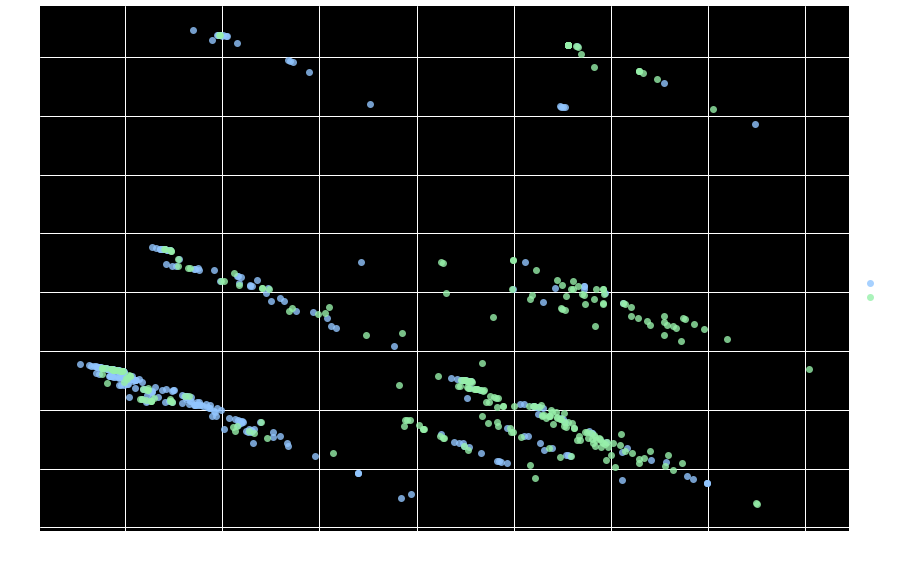

In [71]:
df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df['Class'] = pd.DataFrame(np.array(y_train),index=None)

sns.lmplot(x='PC1', y='PC2', data=df, hue='Class', palette='pastel', fit_reg=False, 
           size=8, aspect=1.5)

In [76]:
### モデル検証
from sklearn.model_selection import cross_val_score
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=4),
                       LogisticRegression(random_state=1))
params_lr = [10**(-4+i) for i in range(6)]
param_grid_lr = [{'logisticregression__C': params_lr}]

### LinearRegression
gs = GridSearchCV(estimator=pipe_lr,param_grid=param_grid_lr,
                 scoring='accuracy', cv=2, n_jobs=-1)
gs = gs.fit(X_train, y_train)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print(' Linear Regression')
print('average: %f, variation: %f'% (np.mean(scores), np.std(scores)))
print('best is %s'% gs.best_params_)

 Linear Regression
average: 0.790628, variation: 0.026871
best is {'logisticregression__C': 0.001}
